In [1]:
import pandas as pd
import sqlite3
import pandasql
import matplotlib.pyplot as plt
import string

In [2]:
df_p = pd.read_csv('data/tn.movie_budgets.csv.gz')
df_g = pd.read_csv('data/tmdb.movies.csv.gz')

con = sqlite3.connect("data/im.db")
df_r = pd.read_sql("""
    SELECT movie_id, primary_title, start_year, runtime_minutes 
    FROM movie_basics
    WHERE runtime_minutes IS NOT NULL
    ;
    """, con)

In [3]:
set_year = 2000
set_profit = 10

In [4]:
df_p['year'] = [int(i[-4:]) for i in df_p.release_date]
df_p.sort_values(by = 'year', inplace=True)
df_p = df_p.loc[df_p.year >= set_year]

In [5]:
df_p.production_budget = df_p.production_budget.str.strip("$")
df_p.production_budget.replace(',','', regex=True, inplace=True)
df_p.production_budget = df_p.production_budget.astype(int)
df_p.domestic_gross = df_p.domestic_gross.str.strip("$")
df_p.domestic_gross.replace(',','', regex=True, inplace=True)
df_p.domestic_gross = df_p.domestic_gross.astype(float)
df_p.worldwide_gross = df_p.worldwide_gross.str.strip("$")
df_p.worldwide_gross.replace(',','', regex=True, inplace=True)
df_p.worldwide_gross = df_p.worldwide_gross.astype(float)

In [6]:
df_p['profit'] = round((df_p['worldwide_gross'] - df_p['production_budget']) / 1000000, 2)
df_p.drop(df_p[df_p.worldwide_gross == 0].index, inplace=True)
df_p.sort_values(by = 'profit', inplace=True, ascending=False)
df_p = df_p.loc[df_p.profit > set_profit]
df_p = df_p.drop(columns=[ 
    'id', 
    'release_date'])

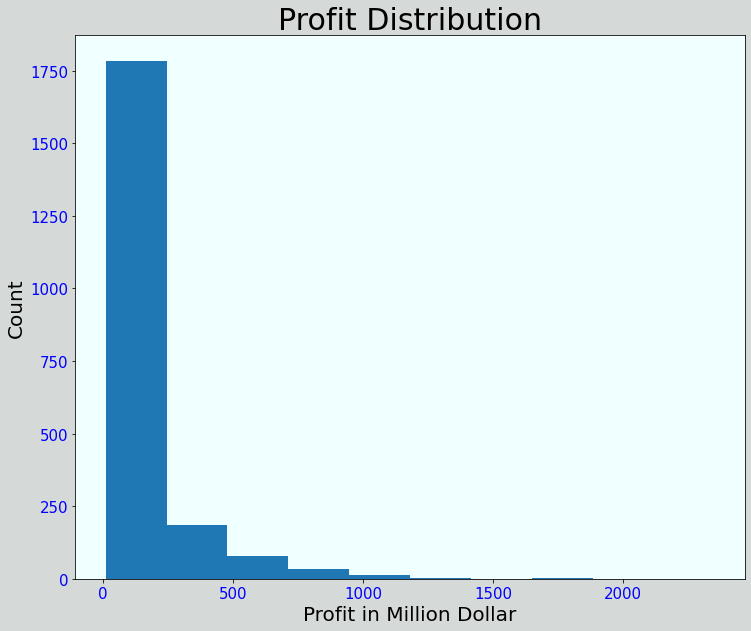

In [7]:
fig, ax = plt.subplots(figsize=(12,10), facecolor=('#d5d9d7'))

x = df_p.profit

ax.set_facecolor('#f0ffff')

ax.hist(x, bins=10)
ax.set_title('Profit Distribution', fontsize=30)
ax.set_xlabel('Profit in Million Dollar', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(labelcolor='#0000ff')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

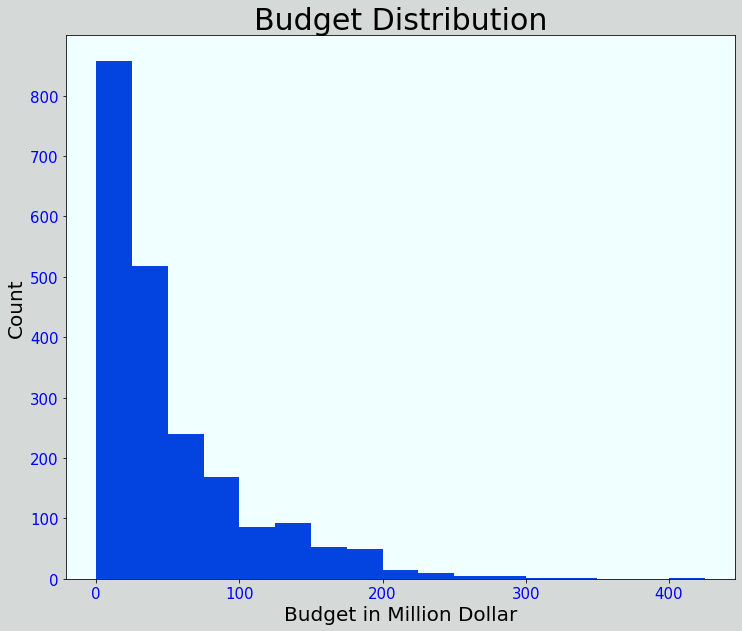

In [8]:
fig, ax = plt.subplots(figsize=(12,10), facecolor=('#d5d9d7'))

x = df_p.production_budget.loc[df_p.production_budget > 0] / 1000000

ax.set_facecolor('#f0ffff')

ax.hist(x, bins=17, color = '#0343df')
ax.set_title('Budget Distribution', fontsize=30)
ax.set_xlabel('Budget in Million Dollar', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(labelcolor='#0000ff')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

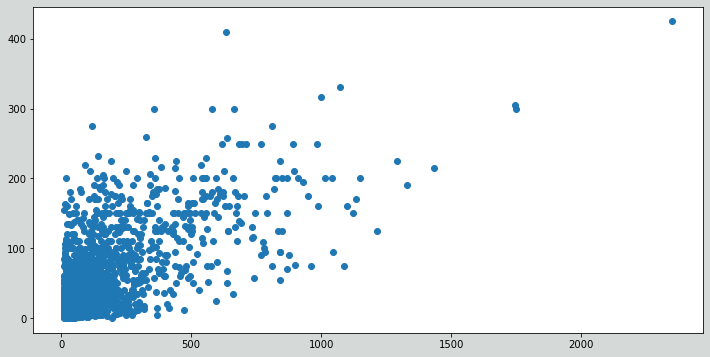

In [9]:
fig, ax = plt.subplots(figsize=(12,6), facecolor=('#d5d9d7'))

x = df_p.profit.loc[df_p.production_budget > 0]
y = df_p.production_budget.loc[df_p.production_budget > 0] / 1000000

ax.scatter(x, y);

In [10]:
# https://www.codegrepper.com/code-examples/python/how+to+remove+periods+in+a+datafrane+pandas
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df_p.movie = df_p.movie.apply(lambda x: x.lower())
df_p.movie = df_p.movie.apply(remove_punctuations)
df_p.movie.replace(' ','', regex=True, inplace=True)

In [11]:
df_g = df_g.drop(columns=[
    'Unnamed: 0', 
    'id', 
    'original_title', 
    'original_language', 
    'popularity', 
    'vote_average', 
    'vote_count'])
df_g = df_g.drop_duplicates()

In [12]:
df_g.duplicated().value_counts()

False    25494
dtype: int64

In [13]:
df_g.title = df_g.title.apply(lambda x: x.lower())
df_g.title = df_g.title.apply(remove_punctuations)
df_g.title.replace(' ','', regex=True, inplace=True)

In [14]:
df_genre = df_p.merge(df_g, how = 'inner', left_on = 'movie', right_on = 'title')

In [15]:
#1070
df_genre

,movie,production_budget,domestic_gross,worldwide_gross,year,profit,genre_ids,release_date,title
0,avatar,425000000,760507625.0,2.776345e+09,2009,2351.35,"[28, 12, 14, 878]",2009-12-18,avatar
1,avengersinfinitywar,300000000,678815482.0,2.048134e+09,2018,1748.13,"[12, 28, 14]",2018-04-27,avengersinfinitywar
2,jurassicworld,215000000,652270625.0,1.648855e+09,2015,1433.85,"[28, 12, 878, 53]",2015-06-12,jurassicworld
3,furious7,190000000,353007020.0,1.518723e+09,2015,1328.72,"[28, 80, 53]",2015-04-03,furious7
4,theavengers,225000000,623279547.0,1.517936e+09,2012,1292.94,"[878, 28, 12]",2012-05-04,theavengers
...,...,...,...,...,...,...,...,...,...
1116,thewords,6000000,11494838.0,1.636971e+07,2012,10.37,"[18, 53]",2012-09-07,thewords
1117,beautifulcreatures,50000000,19452138.0,6.028288e+07,2013,10.28,"[14, 18, 10749]",2013-02-14,beautifulcreatures
1118,whatsyournumber,20000000,14011084.0,3.016378e+07,2011,10.16,"[35, 10749]",2011-09-30,whatsyournumber
1119,theedgeofseventeen,9000000,14431633.0,1.909600e+07,2016,10.10,"[35, 18]",2016-11-18,theedgeofseventeen


In [16]:
df_genre.genre_ids.replace(",",'', regex=True, inplace=True)

In [17]:
df_genre.genre_ids[0][1:-1].split()

['28', '12', '14', '878']

In [18]:
Genre = {
'28': 'Action',
'12': 'Adventure',
'16': 'Animation',
'35': 'Comedy',
'80': 'Crime',
'99': 'Documentary',
'18': 'Drama',
'10751': 'Family',
'14': 'Fantasy',
'36': 'History',
'27': 'Horror',
'10402': 'Music',
'9648': 'Mystery',
'10749': 'Romance',
'878': 'SciFi',
'10770': 'TV_Movie',
'53': 'Thriller',
'10752': 'War',
'37': 'Western'
}

In [19]:
def get_count(number):
    genre = 0
    for i in df_genre.genre_ids:
        for jn in i[1:-1].split():
            if jn == number:
                genre += 1
            else:
                pass
    return genre

In [20]:
Genre_name = []
Genre_count = []
for key, value in Genre.items():
    Genre_name.append(value)
    Genre_count.append(get_count(key))
    
Genre = pd.DataFrame(
    {
        'Genre_name': Genre_name,
        'Genre_count': Genre_count
    }
    )

Genre.sort_values(by = 'Genre_count', inplace=True)

In [21]:
Genre

,Genre_name,Genre_count
15,TV_Movie,2
18,Western,9
5,Documentary,21
17,War,24
11,Music,25
9,History,37
12,Mystery,81
2,Animation,102
4,Crime,125
13,Romance,140


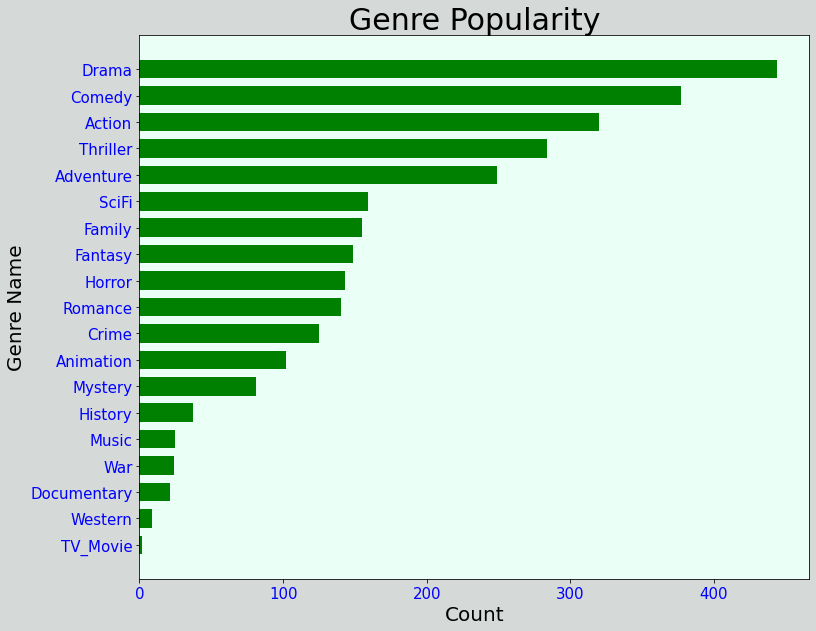

In [22]:
fig, ax = plt.subplots(figsize=(12,10), facecolor=('#d5d9d7'))

y = Genre.Genre_name
x = Genre.Genre_count

ax.set_facecolor('#eafff5')

ax.barh(y, x, height=0.7, color = 'g')
ax.set_title('Genre Popularity', fontsize=30)
ax.set_xlabel('Count', fontsize=20)
ax.set_ylabel('Genre Name', fontsize=20)
ax.tick_params(labelcolor='#0000ff')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [23]:
df_r.primary_title = df_r.primary_title.apply(lambda x: x.lower())
df_r.primary_title = df_r.primary_title.apply(remove_punctuations)
df_r.primary_title.replace(' ','', regex=True, inplace=True)

In [24]:
df_r.duplicated().value_counts()

False    114405
dtype: int64

In [25]:
df_r

,movie_id,primary_title,start_year,runtime_minutes
0,tt0063540,sunghursh,2013,175.0
1,tt0066787,onedaybeforetherainyseason,2019,114.0
2,tt0069049,theothersideofthewind,2018,122.0
3,tt0100275,thewanderingsoapopera,2017,80.0
4,tt0111414,athinlife,2018,75.0
...,...,...,...,...
114400,tt9916170,therehearsal,2019,51.0
114401,tt9916186,illenaudiegeschichteeinerehemaligenheilundpfle...,2017,84.0
114402,tt9916190,safeguard,2019,90.0
114403,tt9916538,kuambillagihatiku,2019,123.0


In [26]:
df_runtime = df_p.merge(df_r, how = 'inner', left_on = 'movie', right_on = 'primary_title')

In [27]:
df_runtime

,movie,production_budget,domestic_gross,worldwide_gross,year,profit,movie_id,primary_title,start_year,runtime_minutes
0,avatar,425000000,760507625.0,2.776345e+09,2009,2351.35,tt1775309,avatar,2011,93.0
1,avengersinfinitywar,300000000,678815482.0,2.048134e+09,2018,1748.13,tt4154756,avengersinfinitywar,2018,149.0
2,jurassicworld,215000000,652270625.0,1.648855e+09,2015,1433.85,tt0369610,jurassicworld,2015,124.0
3,furious7,190000000,353007020.0,1.518723e+09,2015,1328.72,tt2820852,furious7,2015,137.0
4,theavengers,225000000,623279547.0,1.517936e+09,2012,1292.94,tt0848228,theavengers,2012,143.0
...,...,...,...,...,...,...,...,...,...,...
1507,thewords,6000000,11494838.0,1.636971e+07,2012,10.37,tt1840417,thewords,2012,102.0
1508,beautifulcreatures,50000000,19452138.0,6.028288e+07,2013,10.28,tt1559547,beautifulcreatures,2013,124.0
1509,whatsyournumber,20000000,14011084.0,3.016378e+07,2011,10.16,tt0770703,whatsyournumber,2011,106.0
1510,theedgeofseventeen,9000000,14431633.0,1.909600e+07,2016,10.10,tt1878870,theedgeofseventeen,2016,104.0


In [28]:
print(len(df_p))
print(len(df_g))
print(len(df_r))

2102
25494
114405


In [29]:
df_genre.duplicated().value_counts()

False    1121
dtype: int64

In [30]:
df_runtime.duplicated().value_counts()

False    1512
dtype: int64

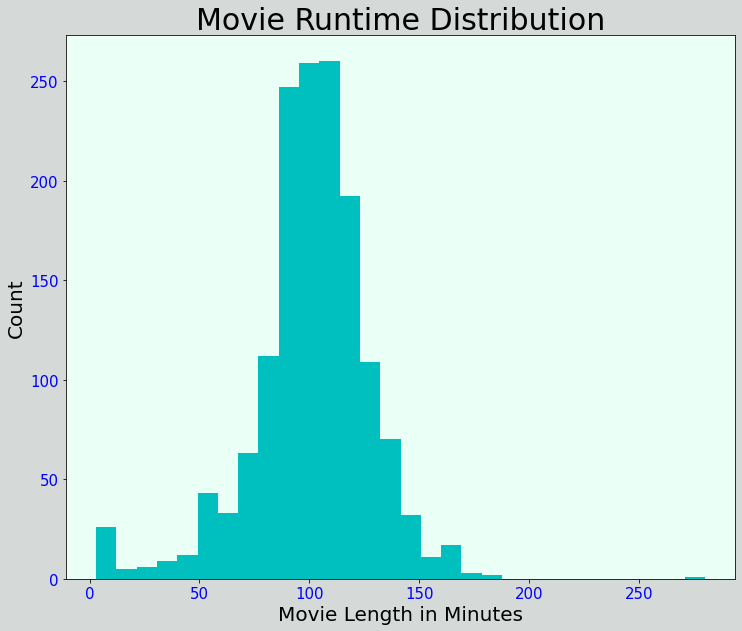

In [37]:
fig, ax = plt.subplots(figsize=(12,10), facecolor=('#d5d9d7'))

x = df_runtime.runtime_minutes

ax.set_facecolor('#eafff5')

ax.hist(x, bins=21, color = 'c')
ax.set_title('Movie Runtime Distribution', fontsize=30)
ax.set_xlabel('Movie Length in Minutes', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(labelcolor='#0000ff')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [32]:
df_runtime.runtime_minutes.min()

3.0